In [1]:
import os
import re
import pendulum as pendulum
from pymongo import MongoClient
import numpy as np
import pandas as pd
import time
from datetime import datetime,timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.set_option('mode.chained_assignment',  None)

In [35]:
# df_quota_byuploadtype 폴더 내의 파일 목록 가져오기
quota_folder = '../raw_data/df_quota_byuploadtype'
quota_files = sorted([file for file in os.listdir(quota_folder) if file.endswith('.csv')])

# 각 월별로 쿼터 사용량을 계산하고 그룹별 유저 수를 저장
monthly_user_counts = {}

for file in quota_files:
    year_month = re.search(r'df_quota_byuploadtype_(\d{4}_\d{2})\.csv', file).group(1)
    df = pd.read_csv(os.path.join(quota_folder, file))
    df = df.drop_duplicates(subset='noteId', keep='first')
    # userId당 쿼터 사용량 계산
    monthly_usage = df.groupby('userId')['value_y'].sum() / 60

    # 쿼터 그룹 나누기
    def categorize_quota(quota):
        if quota < 200:
            return '0-199'
        elif 200 <= quota < 2000:
            return '200-1999'
        else:
            return '2000+'

    monthly_usage = monthly_usage.reset_index()
    monthly_usage['quota_group'] = monthly_usage['value_y'].apply(categorize_quota)

    # 월별로 그룹별 유저 수 계산
    month_user_count = monthly_usage.groupby('quota_group').size()

    # 해당 월의 그룹별 유저 수를 저장
    monthly_user_counts[year_month] = month_user_count

# 데이터프레임 생성
df_user_counts = pd.DataFrame.from_dict(monthly_user_counts, orient='index').fillna(0).reset_index()
df_user_counts.columns.values[0] = 'year_month'

In [36]:
df_user_counts

,year_month,0-199,200-1999,2000+
0,2022_05,191341,60813,1232.0
1,2022_06,192496,54381,462.0
2,2022_07,161680,40347,462.0
3,2022_08,170428,39843,468.0
4,2022_09,205171,70951,2070.0
5,2022_10,214415,82147,1190.0
6,2022_11,200985,79772,2772.0
7,2022_12,195845,64209,511.0
8,2023_01,156842,41231,486.0
9,2023_02,176398,44864,562.0


/tmp/ipykernel_130233/103297078.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  total_group = df_user_counts.sum(axis=1)


<Figure size 1000x500 with 0 Axes>

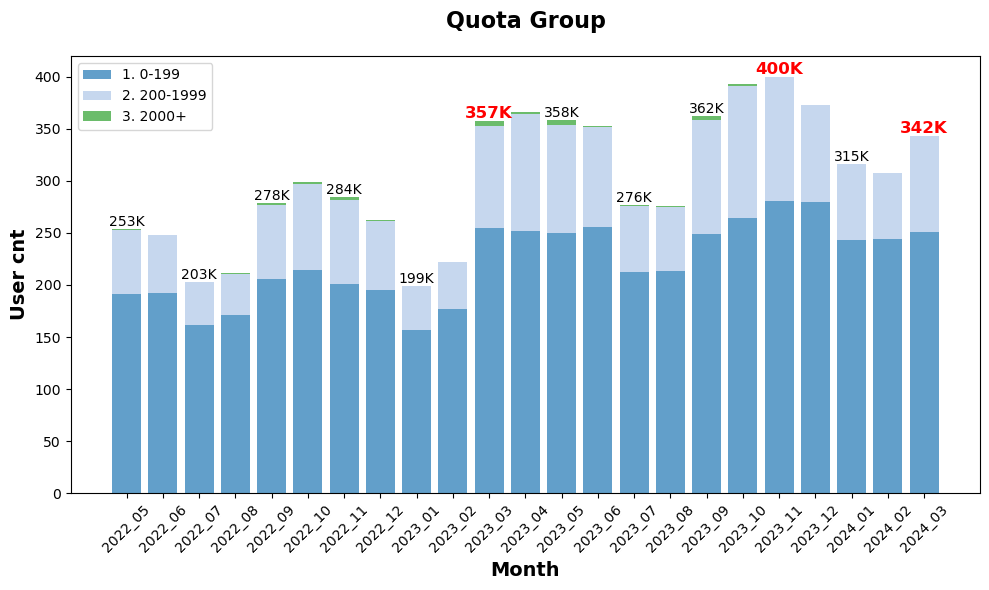

In [14]:
plt.figure(figsize=(10, 5))

x_values = df_user_counts['year_month']
group_0_199 = df_user_counts['0-199']
group_200_1999 = df_user_counts['200-1999']
group_2000 = df_user_counts['2000+']

# 월별 누적 그래프 그리기
colors = ['#1f77b4', '#aec7e8', '#2ca02c']
plt.figure(figsize=(10, 6))
plt.bar(x_values, group_0_199, label = '1. 0-199', color = colors[0], alpha=0.7)
plt.bar(x_values, group_200_1999, bottom = group_0_199, label = '2. 200-1999', color = colors[1], alpha=0.7)
plt.bar(x_values, group_2000, bottom = group_0_199+group_200_1999 ,label = '3. 2000+', color = colors[2], alpha=0.7)\

total_group = df_user_counts.sum(axis=1)

        
highlight_months = {'2024_03', '2023_11', '2023_03'}

for i, quota in enumerate(total_group):
    month = x_values[i]  # 해당 인덱스의 월을 가져옴
    if month in highlight_months:
        plt.text(i, quota, f'{int(quota/1000)}K', ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    else:
        if i % 2 == 0:
            plt.text(i, quota, f'{int(quota/1000)}K', ha='center', va='bottom')
        

# 그래프에 제목과 축 레이블 추가
plt.title('Quota Group', fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel('Month', fontsize = 14, fontweight = 'bold')
plt.ylabel('User cnt', fontsize = 14, fontweight = 'bold')

# y 축 숫자 표시 형식 변경 (정수 형식으로)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
plt.legend(loc='upper left')

# 그래프 출력
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

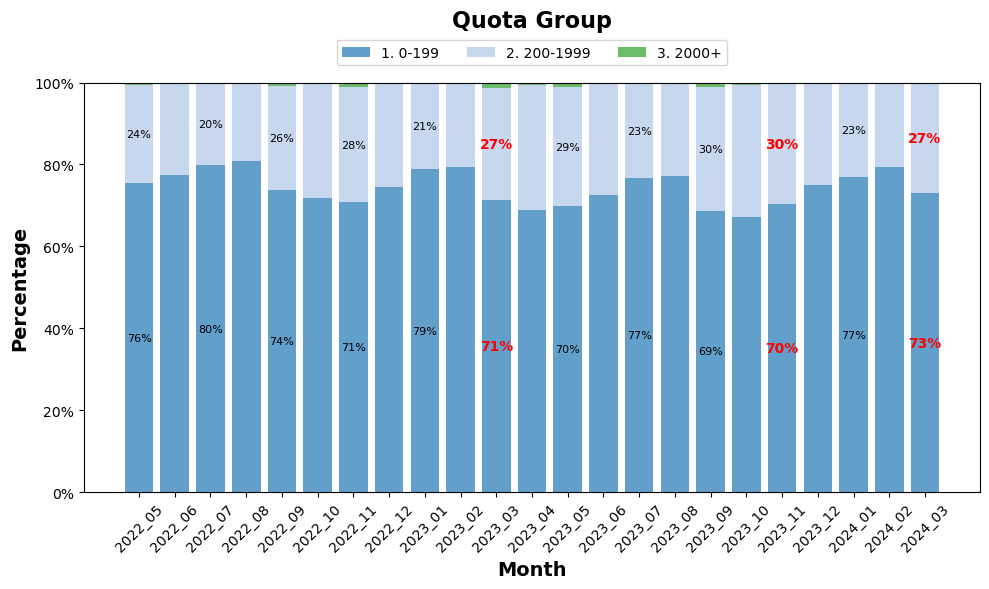

In [13]:
plt.figure(figsize=(10, 5))

x_values = df_user_counts['year_month']
group_0_199 = df_user_counts['0-199']
group_200_1999 = df_user_counts['200-1999']
group_2000 = df_user_counts['2000+']

# 각 그룹의 비율 계산
total = group_0_199 + group_200_1999 + group_2000
percent_group_0_199 = group_0_199 / total * 100
percent_group_200_1999 = group_200_1999 / total * 100
percent_group_2000 = group_2000 / total * 100

# 월별 누적 그래프 그리기
plt.figure(figsize=(10, 6))
bars1=plt.bar(x_values, percent_group_0_199, label='1. 0-199', color='#1f77b4', alpha=0.7)
bars2=plt.bar(x_values, percent_group_200_1999, bottom=percent_group_0_199, label='2. 200-1999', color='#aec7e8', alpha=0.7)
bars3=plt.bar(x_values, percent_group_2000, bottom=percent_group_0_199 + percent_group_200_1999, label='3. 2000+', color='#2ca02c', alpha=0.7)


highlight_months = {'2024_03', '2023_11', '2023_03'}


for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    month = x_values[i]  # 해당 인덱스의 월을 가져옴
    if month in highlight_months:
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        height3 = bar3.get_height()
        plt.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f'{height1:.0f}%', ha='center', va='center', color='red', fontsize=10, fontweight = 'bold')
        plt.text(bar2.get_x() + bar2.get_width() / 2, height1 + height2 / 2, f'{height2:.0f}%', ha='center', va='center', color='red', fontsize=10, fontweight = 'bold')
    else:
        if i % 2 == 0:
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            height3 = bar3.get_height()
            plt.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f'{height1:.0f}%', ha='center', va='center', color='black', fontsize=8)
            plt.text(bar2.get_x() + bar2.get_width() / 2, height1 + height2 / 2, f'{height2:.0f}%', ha='center', va='center', color='black', fontsize=8)



plt.title('Quota Group', fontsize=16, fontweight='bold', pad=40)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Percentage', fontsize=14, fontweight='bold')

# y 축 숫자 표시 형식 변경 (정수 형식으로)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

# y 축 범위 설정
plt.ylim(0, 100)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, fancybox=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()